### Import libraries and upload dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [52]:
# all user IDs are unique, with no duplicate values
df = pd.read_excel(r"mobile_app_task.xlsx", parse_dates=["install_date"]).drop(columns=["user_id"])
df.sample(10)

,install_date,country,test_group,trial,paid,subscription_name,revenue_1m
4052,2023-06-04,AU,treatment,0,0,NaN,0.0
6063,2023-06-04,US,treatment,0,0,NaN,0.0
12745,2023-06-04,AU,control,0,0,NaN,0.0
8004,2023-06-03,US,control,0,0,NaN,0.0
6508,2023-06-01,CA,control,0,0,NaN,0.0
6616,2023-06-02,US,treatment,0,0,NaN,0.0
5901,2023-06-04,AU,treatment,1,0,weekly.2.99.3d.trial,0.0
13596,2023-06-04,GB,control,1,0,monthly.5.99.3d.trial,0.0
13363,2023-06-01,GB,treatment,0,0,NaN,0.0
996,2023-06-07,US,treatment,0,0,NaN,0.0


In [36]:
# the missing values are only present in one column, indicating that the user hasn't activated any subscription.
df.isnull().sum()

install_date             0
country                  0
test_group               0
trial                    0
paid                     0
subscription_name    13562
revenue_1m               0
dtype: int64

  test_group  n_users
0  treatment     7658
1    control     7627


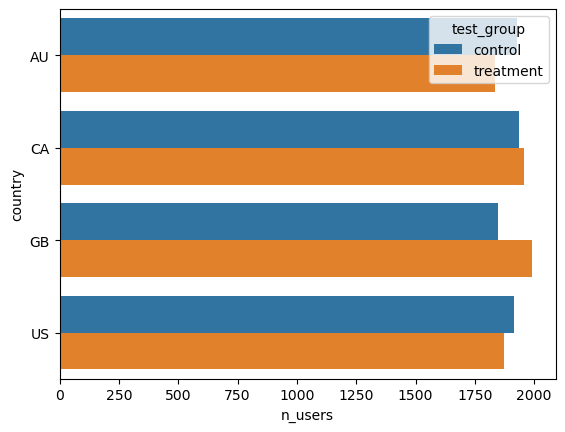

In [37]:
# distribution of users across test groups by country
chart = df.groupby(["country", "test_group"]).size().to_frame("n_users").reset_index()
sns.barplot(chart, x="n_users", y="country", hue="test_group");

print(df["test_group"].value_counts().to_frame("n_users").reset_index())

### Calculations

In [38]:
# 1. Find the number of users who activated the trial period.

trial_period = (
    df.groupby(["country", "test_group"])
    .agg( n_users=("trial", "count"), activated_trial_period=("trial", lambda x: (x == 1).sum()))
    .reset_index()
)

In [39]:
# 2. Find the number of users who made a purchase.

purchases = (
    df.loc[df["trial"] == 1].groupby(["country", "test_group"])
    .agg( made_purchase=("paid", lambda x: (x == 1).sum())).reset_index()
)

In [40]:
# 3. Determine the revenue generated by each testing group.
revenue = df.groupby(["country", "test_group"])["revenue_1m"].sum().to_frame("revenue").reset_index()

In [41]:
# 4. Merge tables together + additional calculated columns.
output = (
    pd.merge(trial_period, purchases, on=["country", "test_group"], how="left")
    .merge(revenue, how="left", on=["country", "test_group"])
)

# Trial period ratio - percentage of users who activate trial period.
output["activated_trial_period_ratio"] = output["activated_trial_period"] / output["n_users"]
# Purchase ratio - percentage of customers who made purchases out of those who activated the trial period.
output["purchases_ratio"] = output["made_purchase"] / output["activated_trial_period"]

output

,country,test_group,n_users,activated_trial_period,made_purchase,revenue,activated_trial_period_ratio,purchases_ratio
0,AU,control,1928,228,30,179.70,0.118257,0.131579
1,AU,treatment,1835,191,39,209.30,0.104087,0.204188
2,CA,control,1936,219,18,107.82,0.113120,0.082192
3,CA,treatment,1959,208,37,185.38,0.106177,0.177885
4,GB,control,1846,270,35,209.65,0.146262,0.129630
5,GB,treatment,1991,209,41,221.26,0.104972,0.196172
6,US,control,1917,208,33,197.67,0.108503,0.158654
7,US,treatment,1873,190,32,176.41,0.101442,0.168421


In [42]:
# export table for power bi
output.to_csv('table_1.csv', index=False)